# **Importing Necessary Libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("viridis")

# **1. Data Loading and Processing**


In [ ]:
def load_and_process_data(file_path):
    """Load and process the FAOSTAT dataset"""
    print(f"Loading data from {file_path}...")

    # Load data
    df = pd.read_csv(file_path)

    # Convert data types
    df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
    df['Value'] = pd.to_numeric(df['Value'], errors='coerce')

    # Remove rows with missing values in key columns
    df = df.dropna(subset=['Year', 'Value', 'Item'])

    # Create a pivot table with crop, year, element
    if 'Element' in df.columns:
        pivot_data = df.pivot_table(
            index=['Item', 'Year'],
            columns='Element',
            values='Value',
            aggfunc='first'
        ).reset_index()

        print(f"Data pivoted successfully. Found elements: {pivot_data.columns.tolist()[2:]}")

        # Calculate missing production values
        if 'Area harvested' in pivot_data.columns and 'Yield' in pivot_data.columns:
            missing_prod = pivot_data['Production'].isna() & pivot_data['Area harvested'].notna() & pivot_data['Yield'].notna()
            if sum(missing_prod) > 0:
                pivot_data.loc[missing_prod, 'Production'] = (
                    pivot_data.loc[missing_prod, 'Area harvested'] * pivot_data.loc[missing_prod, 'Yield'] / 1000
                )
                print(f"Calculated missing production values for {sum(missing_prod)} rows")

        return pivot_data
    else:
        # If dataset doesn't have Element column
        print("Dataset only contains Yield data.")
        return df

# **2. Feature Engineering**


In [ ]:
def engineer_features(data, crop_name):
    """Engineer features for a specific crop"""
    # Filter data for the specific crop
    crop_data = data[data['Item'] == crop_name].copy().sort_values('Year')

    if len(crop_data) < 4:
        print(f"Not enough data for {crop_name}, need at least 4 years")
        return None

    # Add trend features
    crop_data['Year_Squared'] = crop_data['Year'] ** 2

    # Add lag features
    crop_data['Yield_Lag1'] = crop_data['Yield'].shift(1)

    # Add moving average
    crop_data['Yield_MA3'] = crop_data['Yield'].rolling(window=3, min_periods=1).mean()

    # Add growth rate
    crop_data['Yield_Growth'] = crop_data['Yield'].pct_change() * 100

    # Drop rows with NaN values from lag features
    crop_data = crop_data.dropna()

    print(f"Features engineered for {crop_name}. Data shape: {crop_data.shape}")
    return crop_data


# **3. Model Training**

In [ ]:
def train_models(crop_data, test_size=0.2):
    """Train different models and select the best one"""
    if crop_data is None or len(crop_data) < 5:
        print("Insufficient data for model training")
        return None

    # Prepare features and target
    feature_cols = ['Year', 'Year_Squared', 'Yield_Lag1', 'Yield_MA3']

    # Add area harvested if available
    if 'Area harvested' in crop_data.columns:
        feature_cols.append('Area harvested')

    # Ensure all required columns are present
    feature_cols = [col for col in feature_cols if col in crop_data.columns]

    X = crop_data[feature_cols]
    y = crop_data['Yield']

    print(f"Training models using features: {feature_cols}")

    # Initialize models
    models = {
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'Linear Regression': LinearRegression()
    }

    # Dictionary to store results
    results = {}
    best_model = None
    best_score = float('-inf')

    # Split data for validation if we have enough data
    if len(crop_data) >= 6:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

        # Train and evaluate each model
        for name, model in models.items():
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            mse = mean_squared_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)

            # Handle negative R² values
            r2 = max(0, r2)  # Clip negative R² to 0

            # Store results
            results[name] = {
                'model': model,
                'mse': mse,
                'r2': r2
            }

            print(f"{name} - R²: {r2:.4f}, MSE: {mse:.2f}")

            # Update best model
            if r2 > best_score:
                best_score = r2
                best_model = model
    else:
        # Not enough data to split, use all data with Random Forest
        print("Limited data, using Random Forest without validation split")
        best_model = models['Random Forest']
        best_model.fit(X, y)

    # If no good model was found, default to Random Forest
    if best_model is None:
        print("No good model found, defaulting to Random Forest")
        best_model = models['Random Forest']
        best_model.fit(X, y)

    # Try ARIMA model
    arima_fitted = None
    try:
        ts_data = crop_data.set_index('Year')['Yield']
        arima_model = ARIMA(ts_data, order=(1,1,0))
        arima_fitted = arima_model.fit()
        print(f"ARIMA model fitted successfully. AIC: {arima_fitted.aic:.2f}")
    except Exception as e:
        print(f"ARIMA model failed: {e}")

    return {
        'best_model': best_model,
        'arima_model': arima_fitted,
        'feature_cols': feature_cols,
        'training_data': crop_data,
        'model_results': results
    }


# **4. Model Evaluation**

In [ ]:
def evaluate_model(model_results):
    """Evaluate model performance and feature importance"""
    if model_results is None or 'best_model' not in model_results:
        print("No model available for evaluation")
        return

    best_model = model_results['best_model']
    feature_cols = model_results['feature_cols']

    # Check if the model is a Random Forest (has feature_importances_)
    if hasattr(best_model, 'feature_importances_'):
        # Get feature importance
        importances = best_model.feature_importances_
        indices = np.argsort(importances)[::-1]

        print("\nFeature Importance:")
        for i in indices:
            if i < len(feature_cols):
                print(f"  {feature_cols[i]}: {importances[i]:.4f}")



#  **5. Forecasting**

In [ ]:
def forecast_crop_yield(model_results, forecast_years=5):
    """Generate forecasts for future years"""
    if model_results is None or 'best_model' not in model_results:
        print("No model available for forecasting")
        return None

    training_data = model_results['training_data']
    best_model = model_results['best_model']
    arima_model = model_results['arima_model']
    feature_cols = model_results['feature_cols']

    # Get the latest year and yield
    last_year = training_data['Year'].max()
    last_yield = training_data['Yield'].iloc[-1]

    print(f"Forecasting from last year {last_year} (yield: {last_yield:.2f})")

    # Generate future years
    future_years = np.arange(last_year + 1, last_year + forecast_years + 1)

    # Create forecast DataFrame
    future_df = pd.DataFrame({'Year': future_years})
    future_df['Year_Squared'] = future_df['Year'] ** 2

    # Handle lag features
    ml_predictions = np.zeros(forecast_years)

    if 'Yield_Lag1' in feature_cols:
        # Initialize for iterative forecasting
        prev_yield = last_yield
        ma_values = list(training_data['Yield'].tail(3))

        for i in range(forecast_years):
            # Set lag feature
            future_df.loc[i, 'Yield_Lag1'] = prev_yield

            # Set moving average
            future_df.loc[i, 'Yield_MA3'] = sum(ma_values) / len(ma_values)

            # Add area harvested if needed
            if 'Area harvested' in feature_cols:
                if i == 0:
                    # For first year, extrapolate from historical data
                    hist_areas = training_data['Area harvested'].tail(3)
                    area_growth_rate = hist_areas.pct_change().mean()
                    if pd.isna(area_growth_rate):
                        area_growth_rate = 0  # Default to no growth if can't be calculated

                    last_area = training_data['Area harvested'].iloc[-1]
                    future_df.loc[i, 'Area harvested'] = last_area * (1 + area_growth_rate)
                else:
                    # For subsequent years, grow from previous forecast
                    future_df.loc[i, 'Area harvested'] = future_df.loc[i-1, 'Area harvested'] * (1 + area_growth_rate)

            # Predict for this year
            features = future_df.loc[i:i, feature_cols]
            predicted = best_model.predict(features)[0]
            ml_predictions[i] = predicted

            # Update for next iteration
            prev_yield = predicted
            ma_values.append(predicted)
            ma_values = ma_values[-3:]  # Keep only last 3
    else:
        # Simple prediction (non-iterative)
        X_future = future_df[['Year', 'Year_Squared']]
        ml_predictions = best_model.predict(X_future)

    # Add ML predictions to DataFrame
    future_df['ML_Yield'] = ml_predictions

    # Generate ARIMA forecast if available
    if arima_model is not None:
        try:
            arima_forecast = arima_model.forecast(steps=forecast_years)
            future_df['ARIMA_Yield'] = arima_forecast.values

            # Combine ML and ARIMA (weighted average)
            future_df['Yield_Forecast'] = 0.7 * future_df['ML_Yield'] + 0.3 * future_df['ARIMA_Yield']
        except Exception as e:
            print(f"ARIMA forecasting failed: {e}, using ML forecast only")
            future_df['Yield_Forecast'] = future_df['ML_Yield']
    else:
        future_df['Yield_Forecast'] = future_df['ML_Yield']

    # Ensure no negative yields
    future_df['Yield_Forecast'] = future_df['Yield_Forecast'].clip(lower=0)

    # Calculate growth rates
    future_df['Growth_From_Last'] = (future_df['Yield_Forecast'] - last_yield) / last_yield * 100
    future_df['YoY_Growth'] = future_df['Yield_Forecast'].pct_change() * 100
    future_df.loc[0, 'YoY_Growth'] = (future_df['Yield_Forecast'].iloc[0] - last_yield) / last_yield * 100

    print("\nForecast results:")
    print(future_df[['Year', 'Yield_Forecast', 'Growth_From_Last']].round(2))

    return {
        'training_data': training_data,
        'forecast': future_df,
        'last_hist_yield': last_yield
    }


# **6. Visualization**

In [ ]:
def visualize_forecast(forecast_result, crop_name):
    """Create visualizations of the forecast"""
    if forecast_result is None:
        return

    training_data = forecast_result['training_data']
    forecast_df = forecast_result['forecast']

    # Plot historical and forecasted yield
    plt.figure(figsize=(12, 6))

    # Historical data
    plt.plot(training_data['Year'], training_data['Yield'], 'o-', color='blue', linewidth=2, label='Historical Yield')

    # Forecast
    plt.plot(forecast_df['Year'], forecast_df['Yield_Forecast'], 'o--', color='red', linewidth=2, label='Forecast')

    # Add confidence interval
    plt.fill_between(
        forecast_df['Year'],
        forecast_df['Yield_Forecast'] * 0.9,
        forecast_df['Yield_Forecast'] * 1.1,
        color='red', alpha=0.2, label='Confidence Interval (±10%)'
    )

    plt.title(f'Yield Forecast for {crop_name}', fontsize=14)
    plt.xlabel('Year')
    plt.ylabel('Yield (kg/ha)')
    plt.grid(True, alpha=0.3)
    plt.legend()

    # Add vertical line separating historical and forecast
    last_hist_year = training_data['Year'].max()
    plt.axvline(x=last_hist_year, color='gray', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

    # Plot growth rates
    plt.figure(figsize=(12, 6))

    # Historical growth rates
    hist_growth = training_data['Yield'].pct_change() * 100
    years = training_data['Year'][1:]
    plt.bar(years, hist_growth[1:], color='blue', alpha=0.6, label='Historical Growth Rate')

    # Forecast growth rates
    plt.bar(forecast_df['Year'], forecast_df['YoY_Growth'], color='red', alpha=0.6, label='Forecast Growth Rate')

    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.title(f'Year-over-Year Yield Growth Rate for {crop_name}', fontsize=14)
    plt.xlabel('Year')
    plt.ylabel('Growth Rate (%)')
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.tight_layout()
    plt.show()


# **7. Complete Crop Analysis**

In [ ]:
def analyze_crop(data, crop_name):
    """Complete pipeline to analyze and forecast a crop"""
    print(f"\n{'='*50}")
    print(f"ANALYZING {crop_name}")
    print(f"{'='*50}")

    # Engineer features
    crop_data = engineer_features(data, crop_name)

    if crop_data is None:
        print(f"Cannot analyze {crop_name} - insufficient data")
        return None

    # Train models
    model_results = train_models(crop_data)

    if model_results is None:
        print(f"Model training failed for {crop_name}")
        return None

    # Evaluate model
    evaluate_model(model_results)

    # Generate forecasts
    forecast_result = forecast_crop_yield(model_results)

    # Visualize results
    visualize_forecast(forecast_result, crop_name)

    return forecast_result


# **8. Analyze Multiple Crops**

In [ ]:
def analyze_multiple_crops(data, crop_list):
    """Analyze multiple crops and collect results"""
    results = {}

    for crop in crop_list:
        result = analyze_crop(data, crop)
        if result is not None:
            results[crop] = result

    return results


# **9. Generate Summary Report**

In [ ]:
def generate_summary_report(results):
    """Create a summary report of forecasts for all crops"""
    if not results:
        print("No forecast results available")
        return

    print(f"\n{'='*50}")
    print("SUMMARY REPORT: CROP YIELD FORECASTS")
    print(f"{'='*50}")

    # Get the forecast years
    sample_crop = list(results.keys())[0]
    forecast_years = results[sample_crop]['forecast']['Year'].tolist()

    # Create summary tables
    yield_df = pd.DataFrame(index=results.keys(), columns=forecast_years)
    growth_df = pd.DataFrame(index=results.keys(), columns=forecast_years)

    # Fill the tables with forecast data
    for crop, result in results.items():
        forecast = result['forecast']
        for i, year in enumerate(forecast_years):
            yield_df.loc[crop, year] = forecast['Yield_Forecast'].iloc[i]
            growth_df.loc[crop, year] = forecast['Growth_From_Last'].iloc[i]

    # Display summary tables
    print("\nYield Forecasts (kg/ha):")
    print(yield_df.round(2))

    print("\nCumulative Growth from Last Historical Year (%):")
    print(growth_df.round(2))

    # Create comparative plot
    plt.figure(figsize=(12, 8))

    for crop in results.keys():
        # Normalize to percentage of base year
        base_yield = results[crop]['last_hist_yield']
        normalized_forecast = results[crop]['forecast']['Yield_Forecast'] / base_yield * 100

        plt.plot(results[crop]['forecast']['Year'], normalized_forecast, 'o-', linewidth=2, label=crop)

    plt.title('Comparative Yield Growth Forecast (Base Year = 100%)', fontsize=14)
    plt.xlabel('Year')
    plt.ylabel('Yield Index (% of Last Historical Year)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return {
        'yield_forecast': yield_df,
        'growth_forecast': growth_df
    }

# **Main Execution**


Loading data from /content/FAOSTAT_data_en_4-9-2025 (new).csv...
Data pivoted successfully. Found elements: ['Area harvested', 'Production', 'Yield']

ANALYZING Rice
Features engineered for Rice. Data shape: (5, 9)
Training models using features: ['Year', 'Year_Squared', 'Yield_Lag1', 'Yield_MA3', 'Area harvested']
Limited data, using Random Forest without validation split
ARIMA model fitted successfully. AIC: 49.02

Feature Importance:
  Yield_MA3: 0.2472
  Year: 0.2311
  Area harvested: 0.2106
  Year_Squared: 0.2008
  Yield_Lag1: 0.1104
Forecasting from last year 2023 (yield: 4322.30)

Forecast results:
   Year  Yield_Forecast  Growth_From_Last
0  2024         4306.91             -0.36
1  2025         4310.50             -0.27
2  2026         4312.04             -0.24
3  2027         4312.70             -0.22
4  2028         4312.99             -0.22


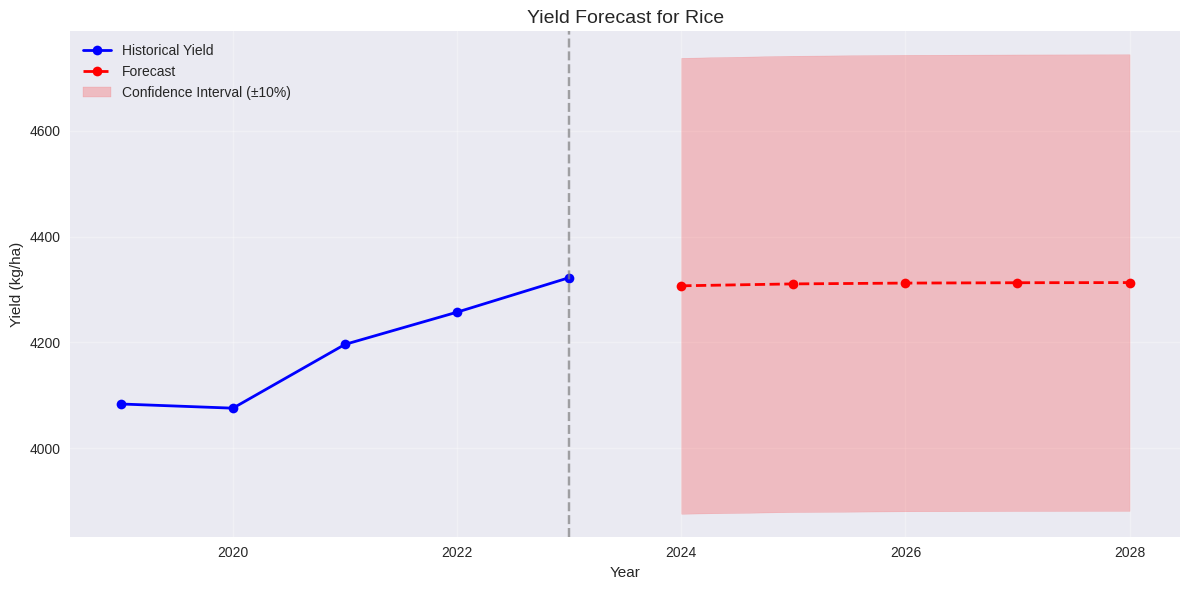

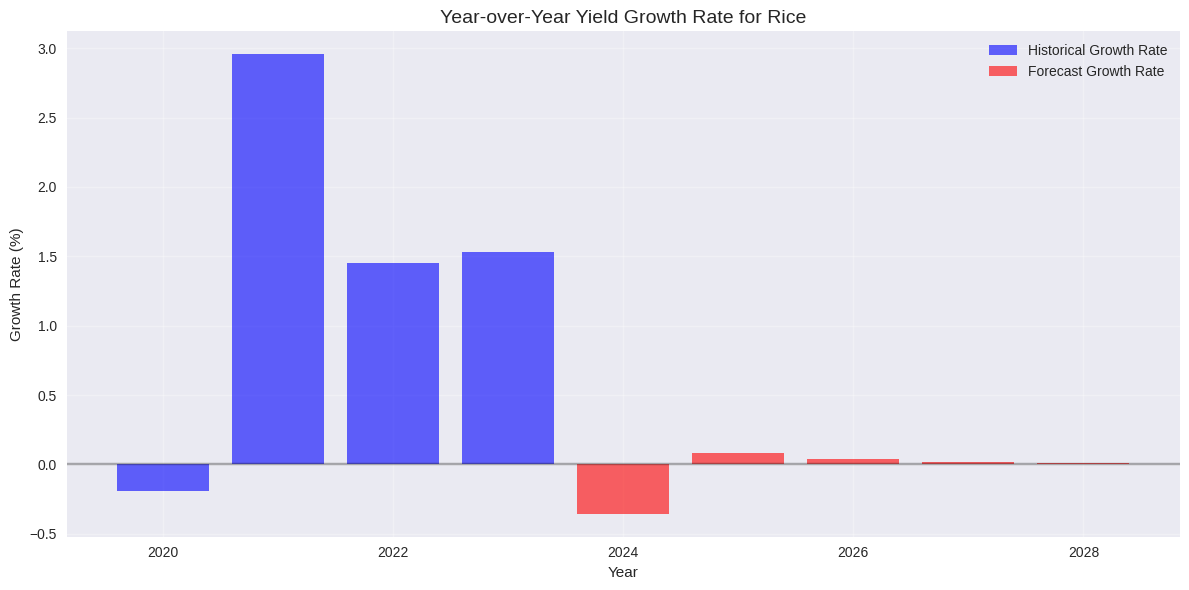


ANALYZING Wheat
Features engineered for Wheat. Data shape: (5, 9)
Training models using features: ['Year', 'Year_Squared', 'Yield_Lag1', 'Yield_MA3', 'Area harvested']
Limited data, using Random Forest without validation split
ARIMA model fitted successfully. AIC: 46.90

Feature Importance:
  Yield_MA3: 0.4428
  Area harvested: 0.2595
  Year: 0.1123
  Yield_Lag1: 0.0935
  Year_Squared: 0.0918
Forecasting from last year 2023 (yield: 3520.70)

Forecast results:
   Year  Yield_Forecast  Growth_From_Last
0  2024         3521.43              0.02
1  2025         3519.37             -0.04
2  2026         3520.70             -0.00
3  2027         3519.85             -0.02
4  2028         3520.39             -0.01


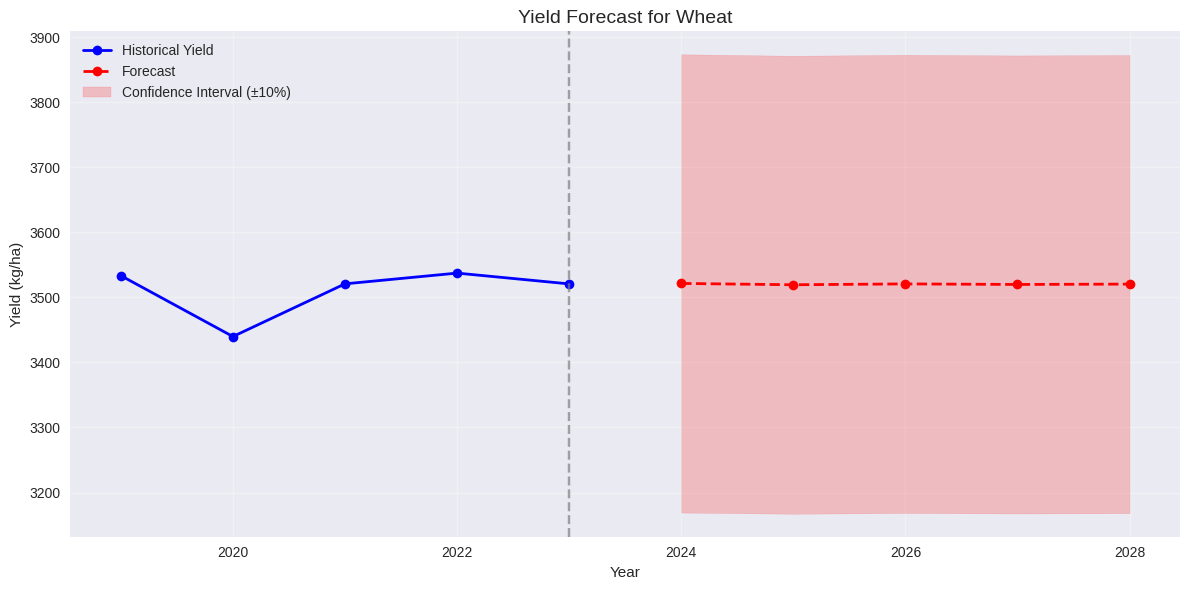

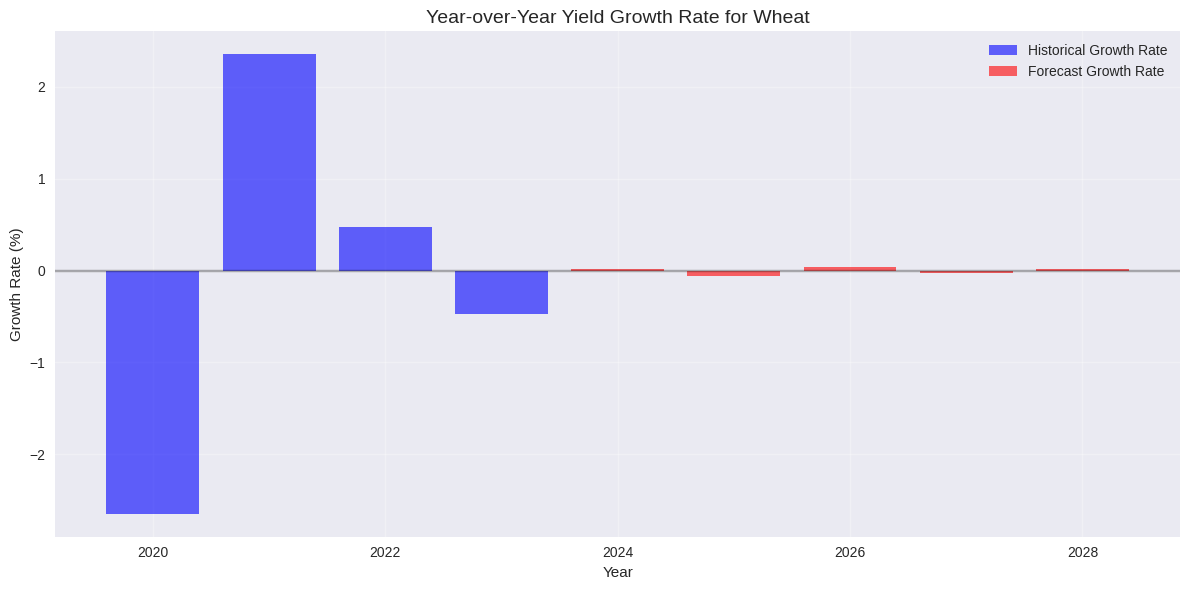


ANALYZING Maize (corn)
Features engineered for Maize (corn). Data shape: (5, 9)
Training models using features: ['Year', 'Year_Squared', 'Yield_Lag1', 'Yield_MA3', 'Area harvested']
Limited data, using Random Forest without validation split
ARIMA model fitted successfully. AIC: 54.74

Feature Importance:
  Year: 0.2182
  Yield_MA3: 0.2034
  Area harvested: 0.2024
  Yield_Lag1: 0.1961
  Year_Squared: 0.1799
Forecasting from last year 2023 (yield: 3544.90)

Forecast results:
   Year  Yield_Forecast  Growth_From_Last
0  2024         3512.93             -0.90
1  2025         3525.27             -0.55
2  2026         3531.58             -0.38
3  2027         3534.80             -0.28
4  2028         3536.44             -0.24


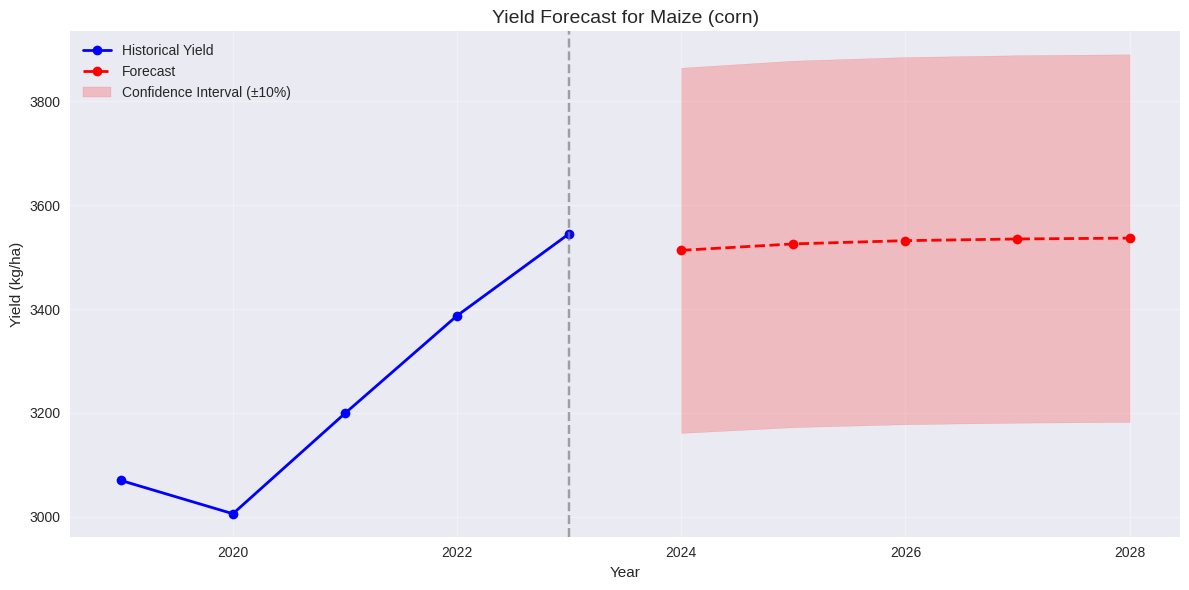

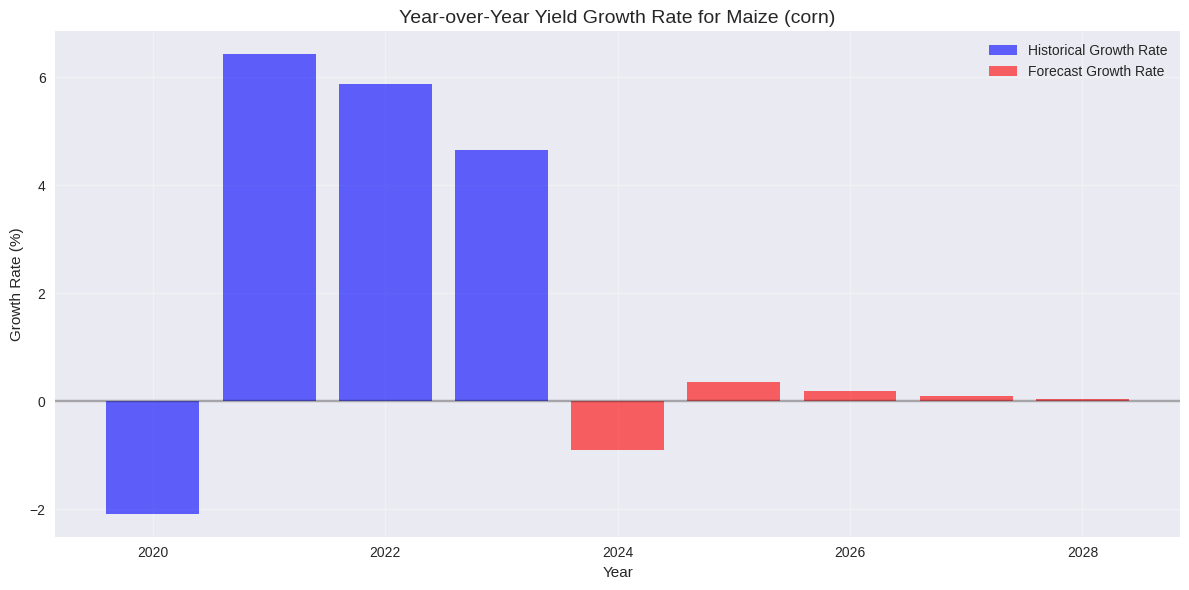


ANALYZING Potatoes
Features engineered for Potatoes. Data shape: (5, 9)
Training models using features: ['Year', 'Year_Squared', 'Yield_Lag1', 'Yield_MA3', 'Area harvested']
Limited data, using Random Forest without validation split
ARIMA model fitted successfully. AIC: 66.65

Feature Importance:
  Yield_Lag1: 0.2382
  Year: 0.2314
  Year_Squared: 0.2109
  Yield_MA3: 0.1986
  Area harvested: 0.1209
Forecasting from last year 2023 (yield: 25789.90)

Forecast results:
   Year  Yield_Forecast  Growth_From_Last
0  2024        25583.44             -0.80
1  2025        25589.00             -0.78
2  2026        25590.02             -0.78
3  2027        25590.20             -0.77
4  2028        25590.24             -0.77


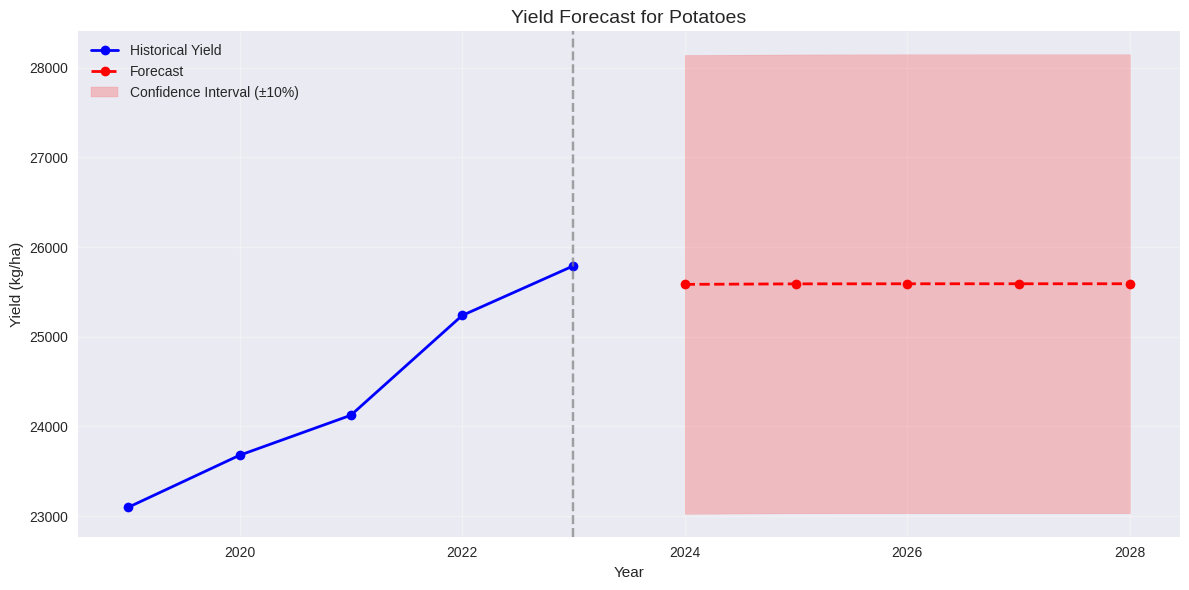

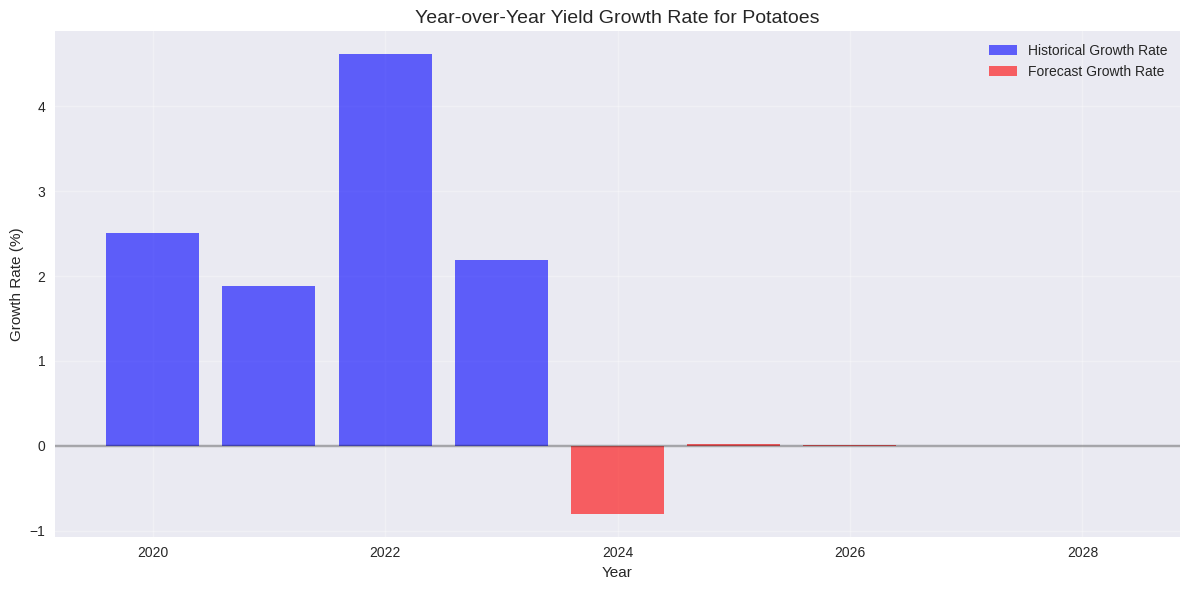


ANALYZING Sugar cane
Features engineered for Sugar cane. Data shape: (5, 9)
Training models using features: ['Year', 'Year_Squared', 'Yield_Lag1', 'Yield_MA3', 'Area harvested']
Limited data, using Random Forest without validation split
ARIMA model fitted successfully. AIC: 75.60

Feature Importance:
  Yield_MA3: 0.2401
  Year: 0.2248
  Year_Squared: 0.2155
  Yield_Lag1: 0.1734
  Area harvested: 0.1461
Forecasting from last year 2023 (yield: 83348.70)

Forecast results:
   Year  Yield_Forecast  Growth_From_Last
0  2024        83676.06              0.39
1  2025        83676.03              0.39
2  2026        83676.03              0.39
3  2027        83676.03              0.39
4  2028        83676.03              0.39


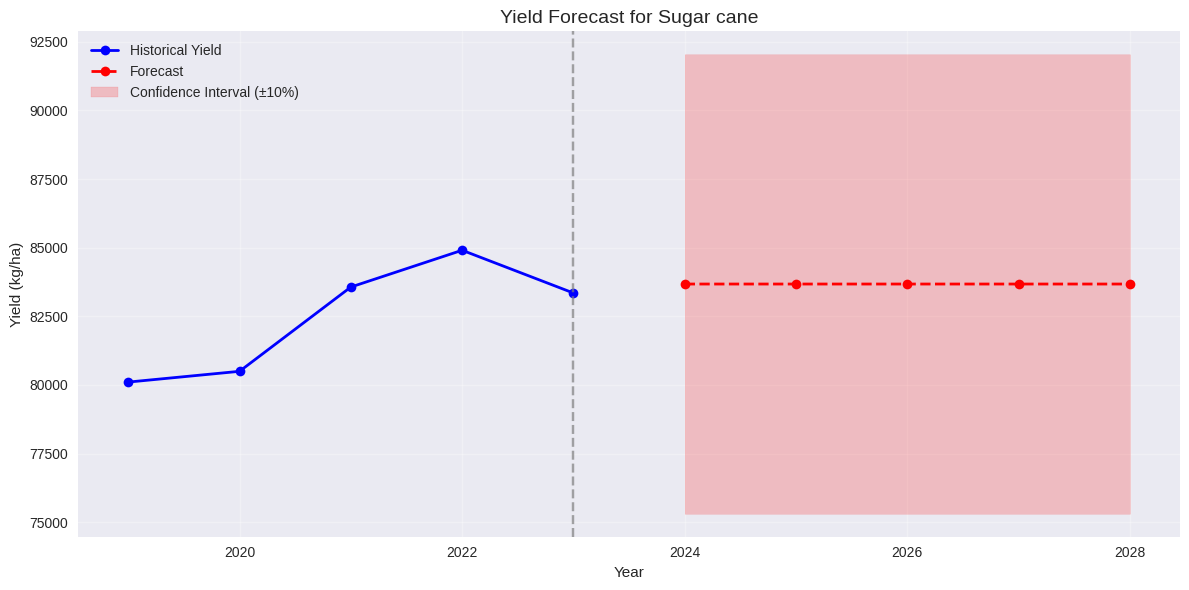

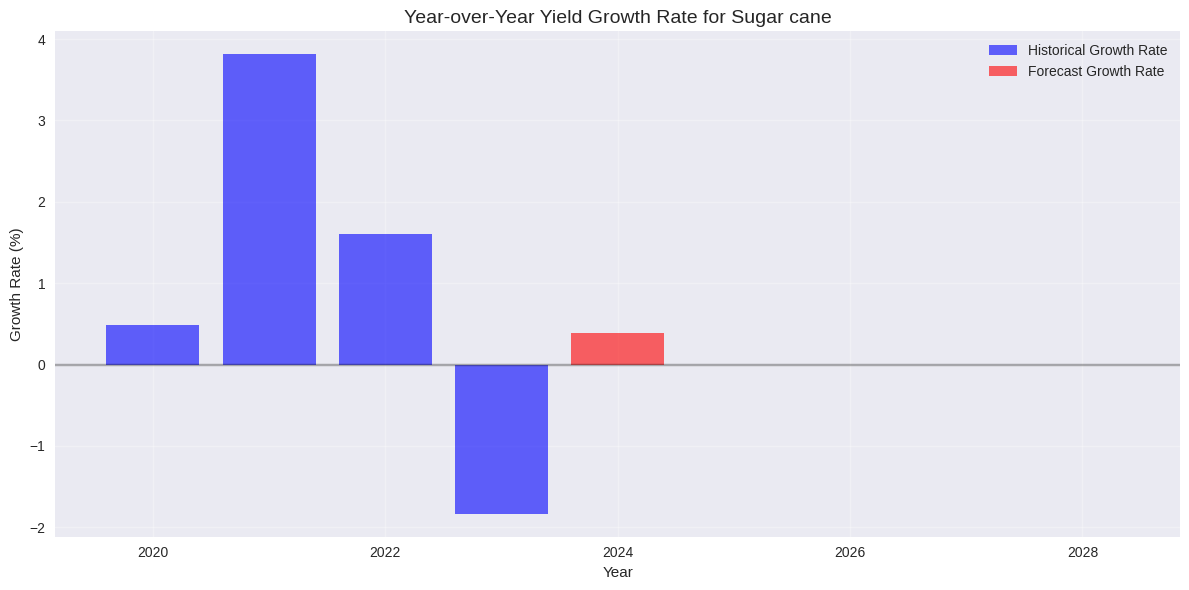


ANALYZING Bananas
Features engineered for Bananas. Data shape: (5, 9)
Training models using features: ['Year', 'Year_Squared', 'Yield_Lag1', 'Yield_MA3', 'Area harvested']
Limited data, using Random Forest without validation split
ARIMA model fitted successfully. AIC: 66.55

Feature Importance:
  Year: 0.2452
  Yield_MA3: 0.2273
  Area harvested: 0.2064
  Year_Squared: 0.1941
  Yield_Lag1: 0.1270
Forecasting from last year 2023 (yield: 36835.00)

Forecast results:
   Year  Yield_Forecast  Growth_From_Last
0  2024        36577.28             -0.70
1  2025        36580.74             -0.69
2  2026        36581.12             -0.69
3  2027        36581.16             -0.69
4  2028        36581.16             -0.69


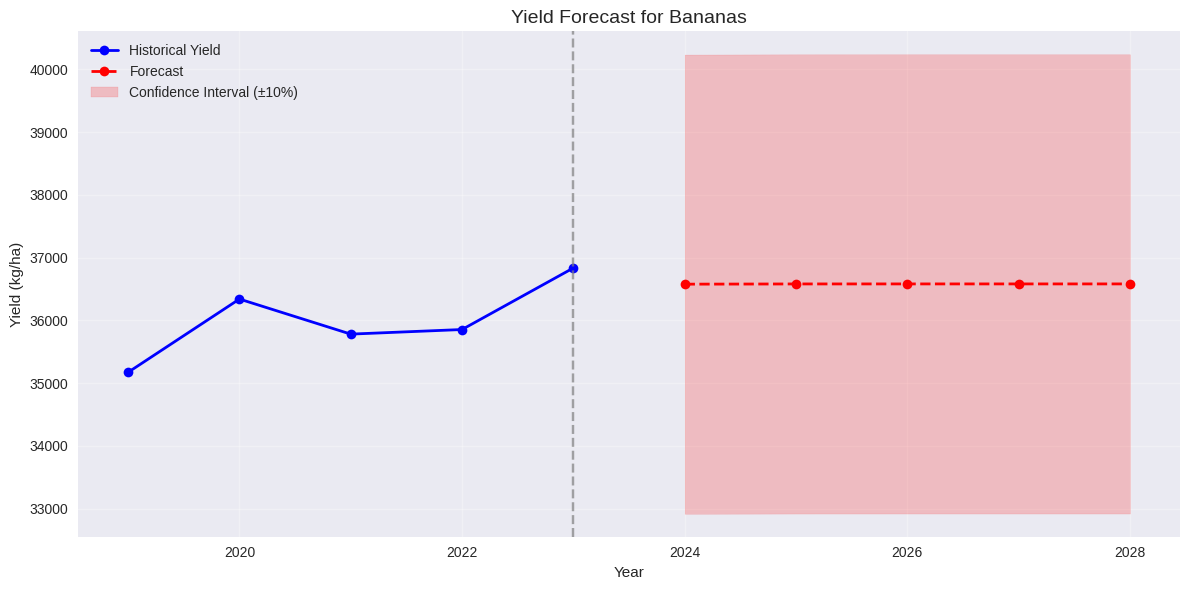

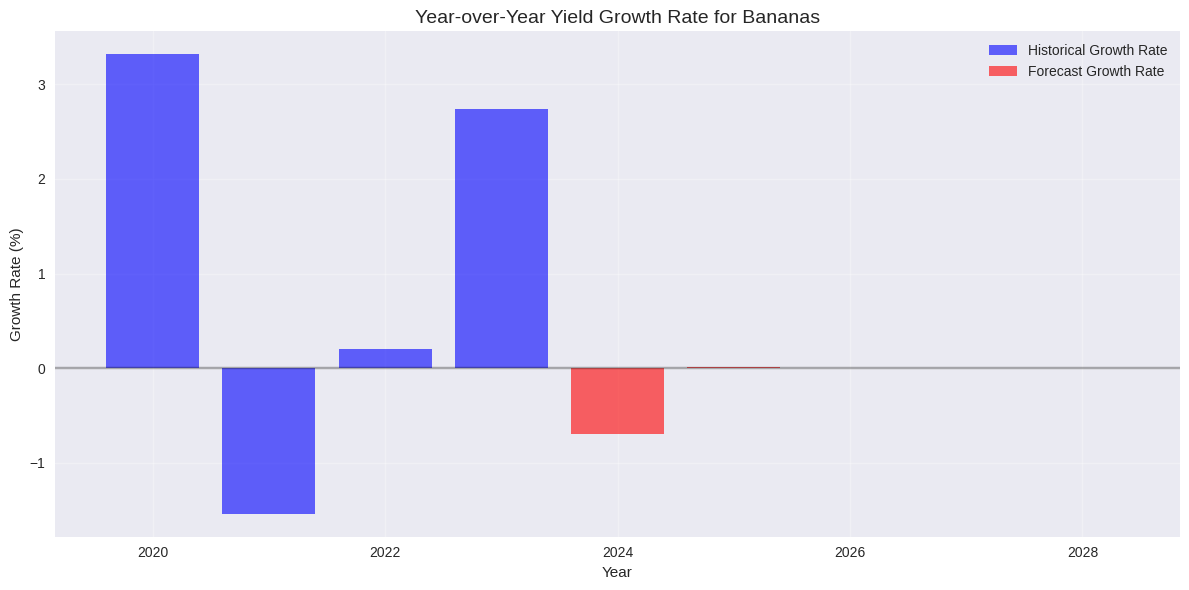


ANALYZING Tomatoes
Features engineered for Tomatoes. Data shape: (5, 9)
Training models using features: ['Year', 'Year_Squared', 'Yield_Lag1', 'Yield_MA3', 'Area harvested']
Limited data, using Random Forest without validation split
ARIMA model fitted successfully. AIC: 61.93

Feature Importance:
  Yield_Lag1: 0.3409
  Yield_MA3: 0.2933
  Year_Squared: 0.1530
  Year: 0.1494
  Area harvested: 0.0635
Forecasting from last year 2023 (yield: 24057.70)

Forecast results:
   Year  Yield_Forecast  Growth_From_Last
0  2024        24282.47              0.93
1  2025        24270.82              0.89
2  2026        24267.55              0.87
3  2027        24266.63              0.87
4  2028        24266.37              0.87


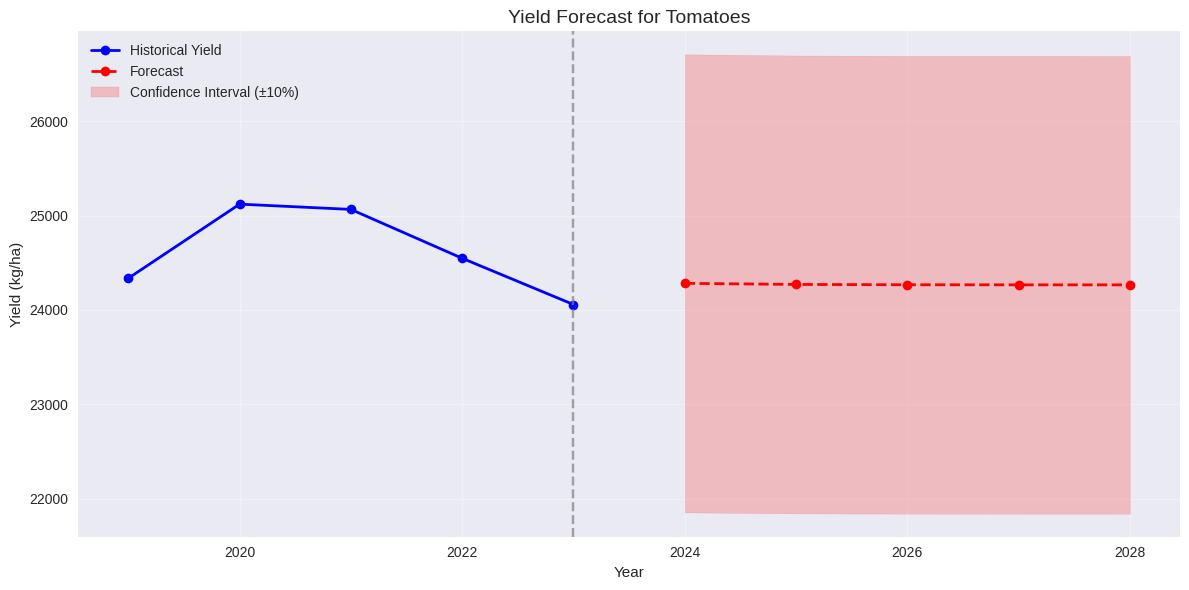

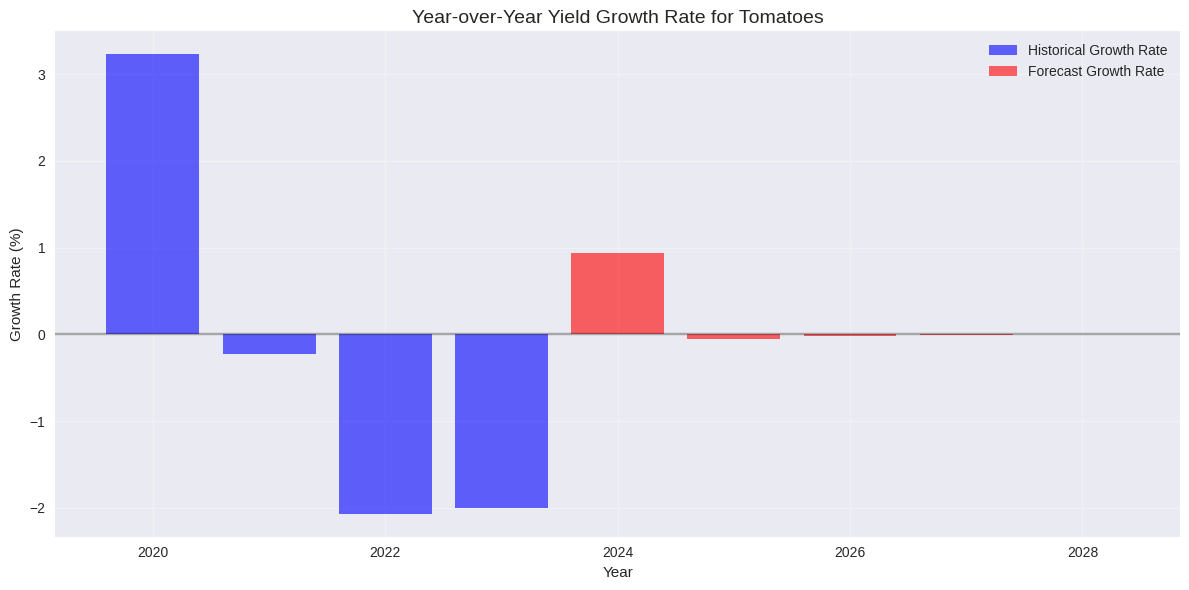


ANALYZING Apples
Features engineered for Apples. Data shape: (5, 9)
Training models using features: ['Year', 'Year_Squared', 'Yield_Lag1', 'Yield_MA3', 'Area harvested']
Limited data, using Random Forest without validation split
ARIMA model fitted successfully. AIC: 73.14

Feature Importance:
  Yield_MA3: 0.3941
  Area harvested: 0.1777
  Yield_Lag1: 0.1565
  Year_Squared: 0.1489
  Year: 0.1228
Forecasting from last year 2023 (yield: 9460.50)

Forecast results:
   Year  Yield_Forecast  Growth_From_Last
0  2024         9169.46             -3.08
1  2025         9176.73             -3.00
2  2026         9177.75             -2.99
3  2027         9177.89             -2.99
4  2028         9177.91             -2.99


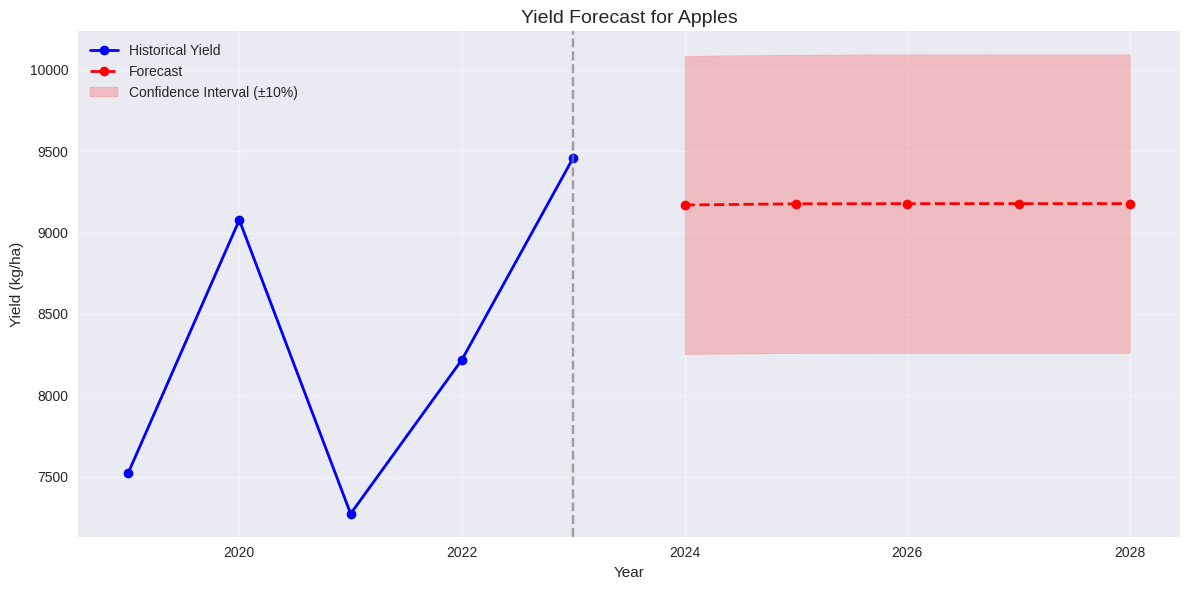

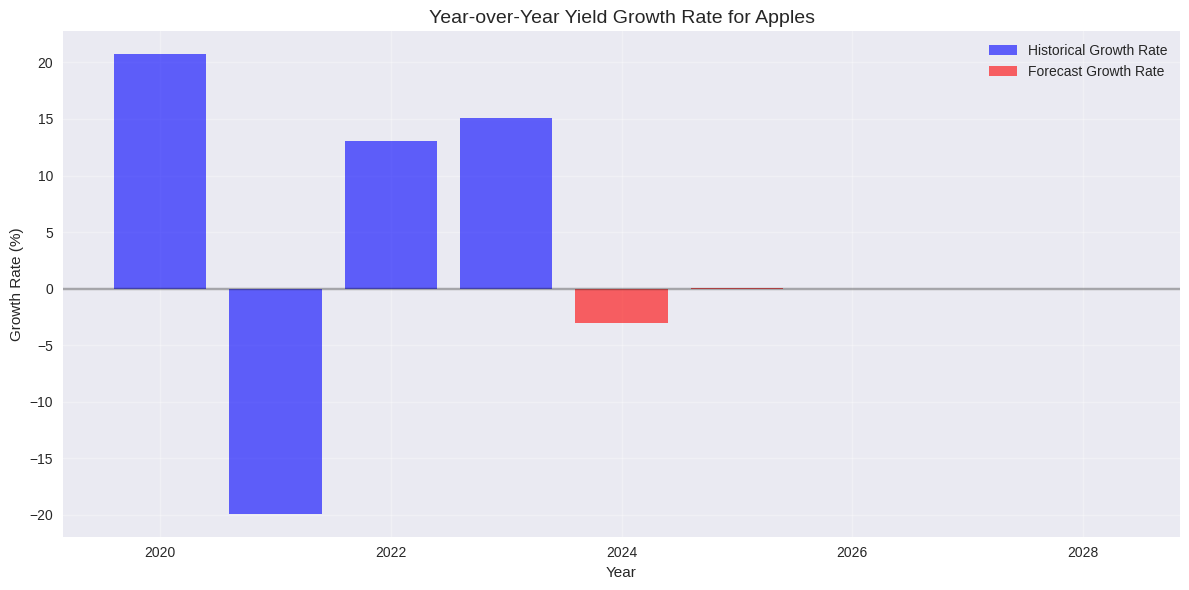


ANALYZING Onions and shallots, dry (excluding dehydrated)
Features engineered for Onions and shallots, dry (excluding dehydrated). Data shape: (5, 9)
Training models using features: ['Year', 'Year_Squared', 'Yield_Lag1', 'Yield_MA3', 'Area harvested']
Limited data, using Random Forest without validation split
ARIMA model fitted successfully. AIC: 71.17

Feature Importance:
  Yield_MA3: 0.2938
  Year: 0.1999
  Area harvested: 0.1990
  Year_Squared: 0.1794
  Yield_Lag1: 0.1279
Forecasting from last year 2023 (yield: 17360.90)

Forecast results:
   Year  Yield_Forecast  Growth_From_Last
0  2024        17089.00             -1.57
1  2025        16982.43             -2.18
2  2026        16982.42             -2.18
3  2027        16982.42             -2.18
4  2028        17040.43             -1.85


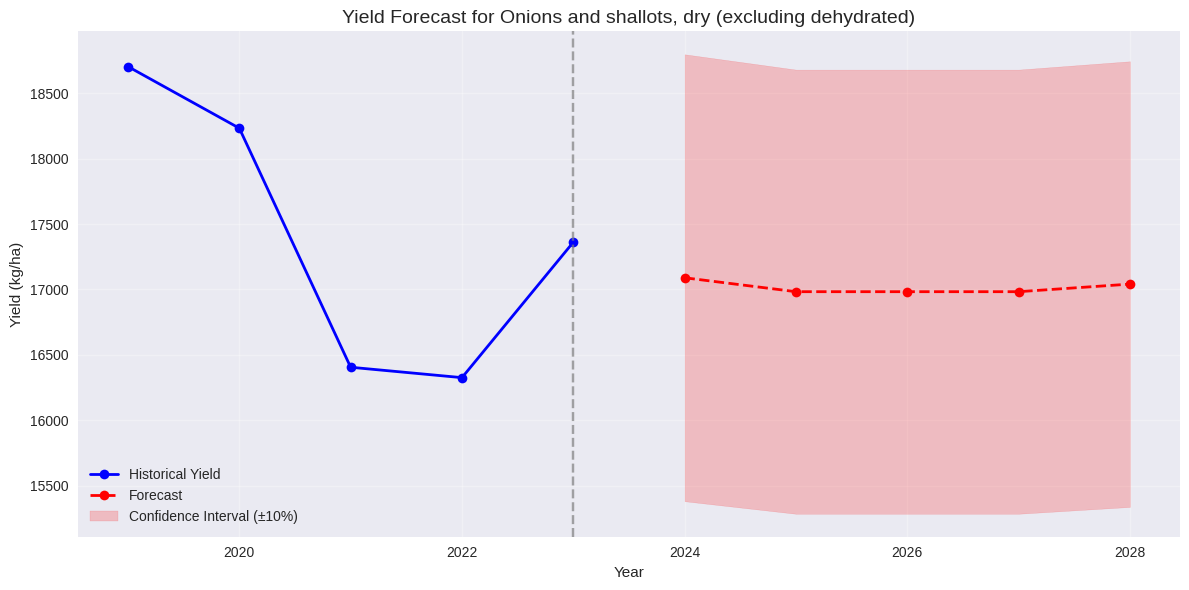

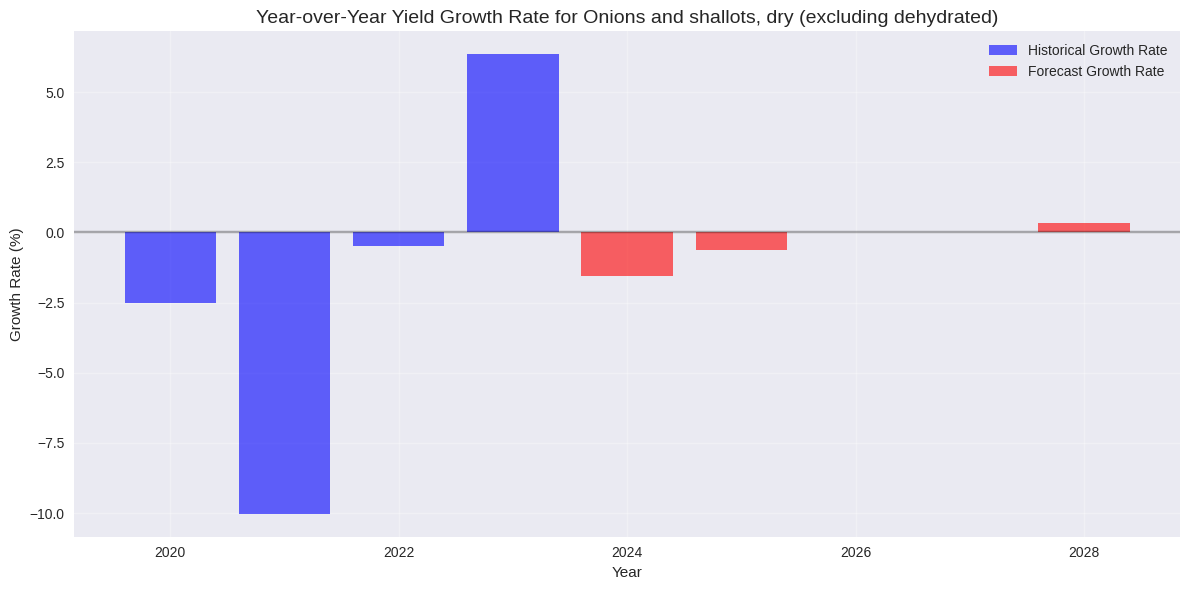


SUMMARY REPORT: CROP YIELD FORECASTS

Yield Forecasts (kg/ha):
                                                         2024          2025  \
Rice                                              4306.906615   4310.502232   
Wheat                                             3521.434253   3519.373074   
Maize (corn)                                      3512.927591   3525.271805   
Potatoes                                         25583.441422  25589.001512   
Sugar cane                                       83676.056589  83676.034987   
Bananas                                          36577.275939   36580.73933   
Tomatoes                                         24282.466128  24270.823647   
Apples                                            9169.455807    9176.73244   
Onions and shallots, dry (excluding dehydrated)   17088.99735  16982.433209   

                                                         2026          2027  \
Rice                                              4312.043847   43

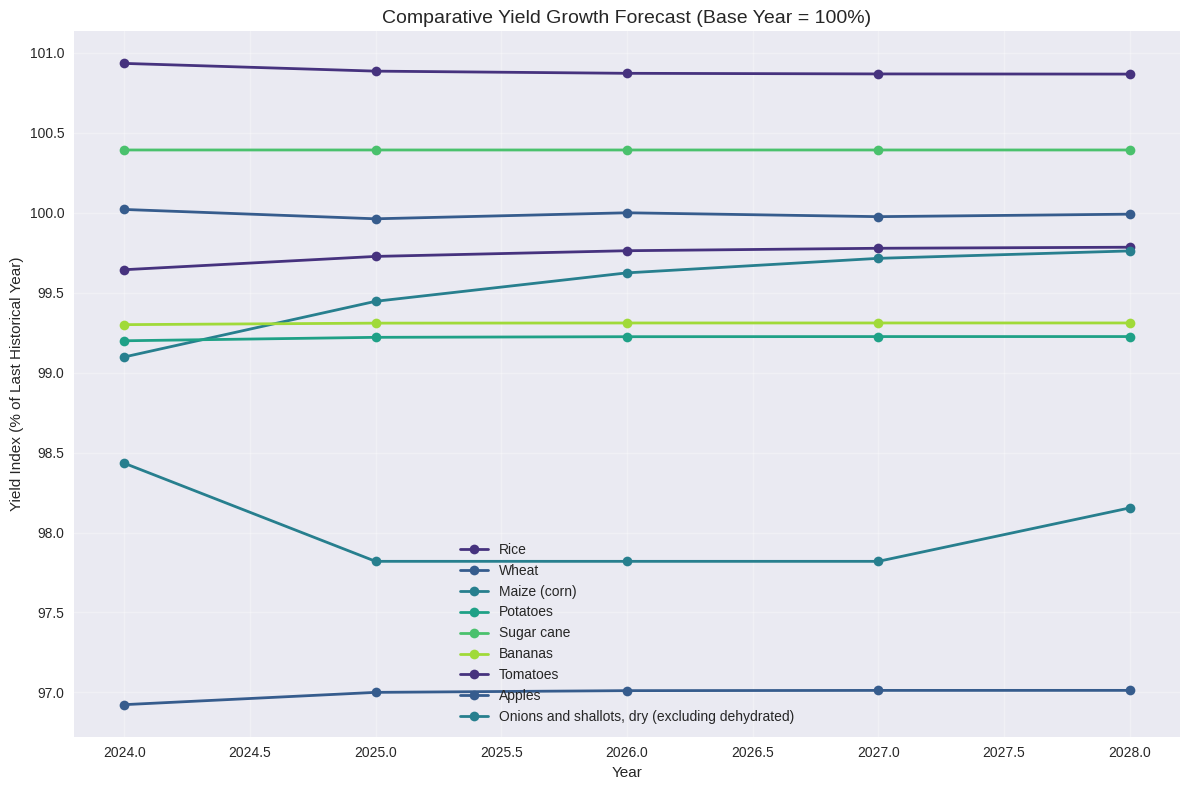

In [ ]:
def main():
    # Load and process the data
    file_path = '/content/FAOSTAT_data_en_4-9-2025 (new).csv'
    data = load_and_process_data(file_path)

    # List of crops to analyze
    crops_to_analyze = [
        'Rice', 'Wheat', 'Maize (corn)', 'Potatoes', 'Sugar cane',
        'Bananas', 'Tomatoes', 'Apples', 'Onions and shallots, dry (excluding dehydrated)'
    ]

    # Analyze the crops
    forecast_results = analyze_multiple_crops(data, crops_to_analyze)

    # Generate summary report
    summary_report = generate_summary_report(forecast_results)

    return forecast_results, summary_report

if __name__ == "__main__":
    forecast_results, summary_report = main()